# Orchestrator: Modular AutoML.

## 0. Imports

We just need to import the Orchestrator tool and, with it, comes everything we need to do all the processing.

In [2]:
%load_ext autoreload
%autoreload 2

from orchestrator import MLOrchestrator

## 1. Data Loading:

- The method `.load_data()` takes both strings (to the .csv's path) and already loaded DataFrames, so the input could be any of those.

- As the name says, it'll load the data, store the target column's data and use both to initialize the `DataExplorer` and `Visualizer` tools.

- The `DataExplorer` tool will automatically sort the columns into "Numerical" and "Categorical".

In [3]:
df_path = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"
orch = MLOrchestrator()
orch.load_data(df=df_path, target="Outcome")

✅ Data successfully loaded!
Looks like Outcome is a factorized categorical. Reclassifying...
ℹ️  Column Classification: 8 Numerical | 1 Categorical
🛠️ Tools initialized: DataExplorer & Visualizer ready.


## 2. Data Exploration

The method `.execute_analysis()` has three modes: 

- 'data': only shows a basic univariate analysis of both numerical (through pandas' describe) and categorical (through value_counts) columns. 

- 'visual': plots univariate graphs and correlation plots (the top 3 correlated columns vs the target + full correlation matrix). Make note that, for clear visualization of the data, some filters are applied to not show the outliers. 

- 'all': makes both analysis.


--- 🔍 Starting Analysis (Mode: all) ---

--------------- DATA SUMMARY ---------------
📐 Dimensions:  768 Rows x 9 Columns
📊 Data Types:  1 Categorical, 8 Numerical
✅ Nulls:       None detected.
✅ Duplicates:  None detected.
--------------------------------------------

--------------- UNIVARIATE ANALYSIS ---------------
🔢 Numerical Statistics:
                            count    mean     std    min    25%     50%     75%     max
------------------------  -------  ------  ------  -----  -----  ------  ------  ------
Pregnancies                768.00    3.85    3.37   0.00   1.00    3.00    6.00   17.00
Glucose                    768.00  120.89   31.97   0.00  99.00  117.00  140.25  199.00
BloodPressure              768.00   69.11   19.36   0.00  62.00   72.00   80.00  122.00
SkinThickness              768.00   20.54   15.95   0.00   0.00   23.00   32.00   99.00
Insulin                    768.00   79.80  115.24   0.00   0.00   30.50  127.25  846.00
BMI                        768.00   3

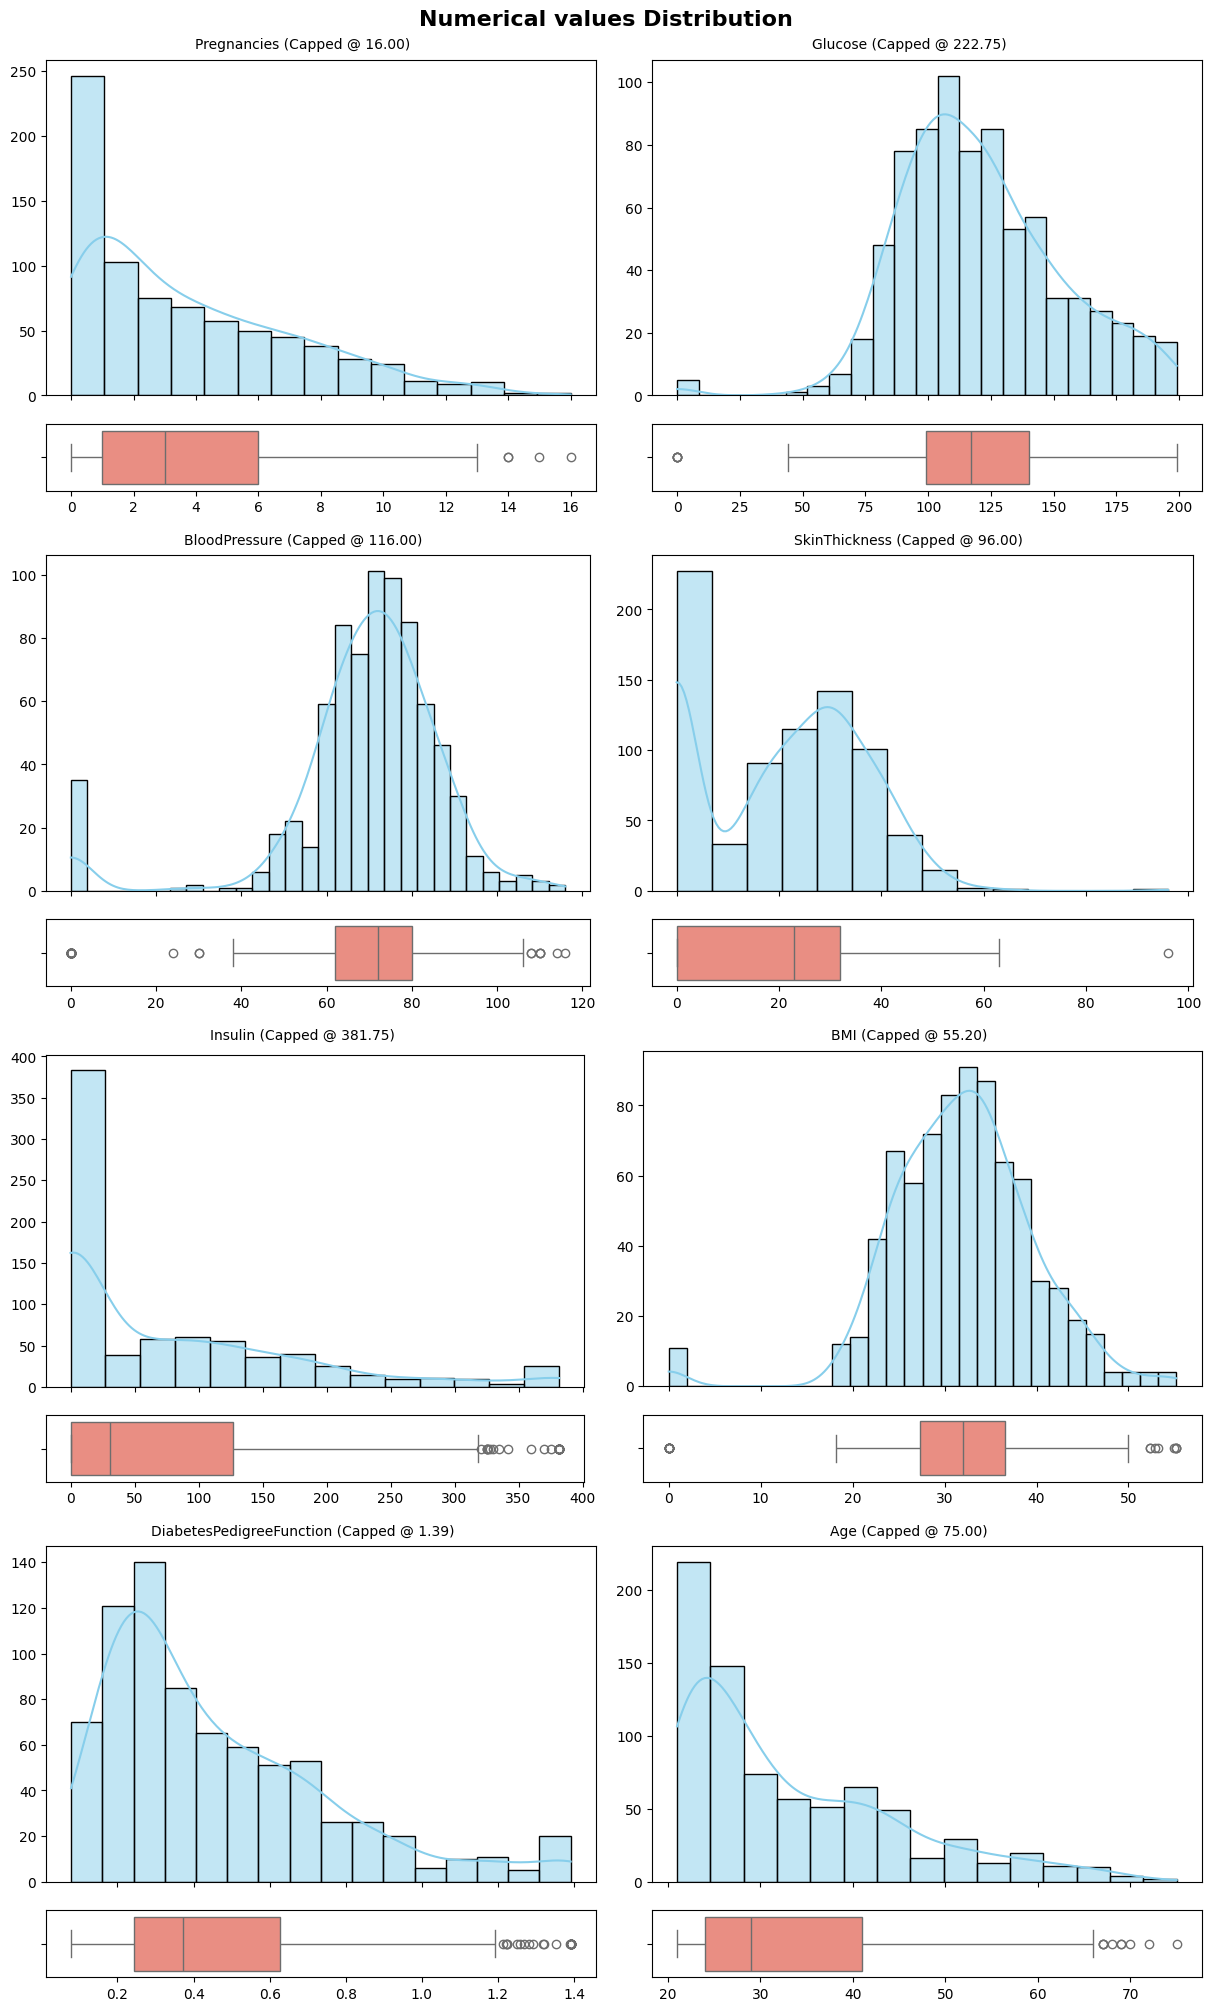

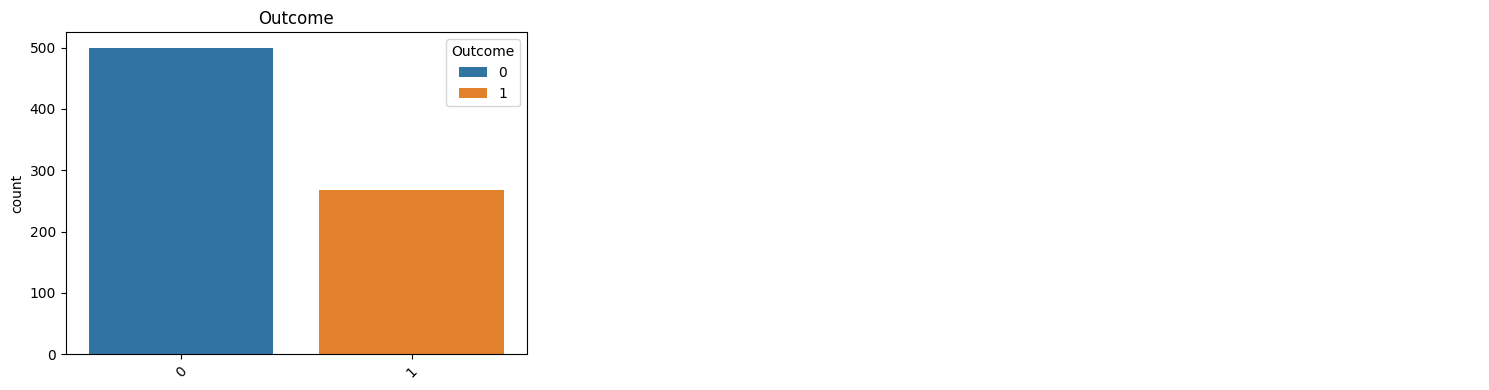

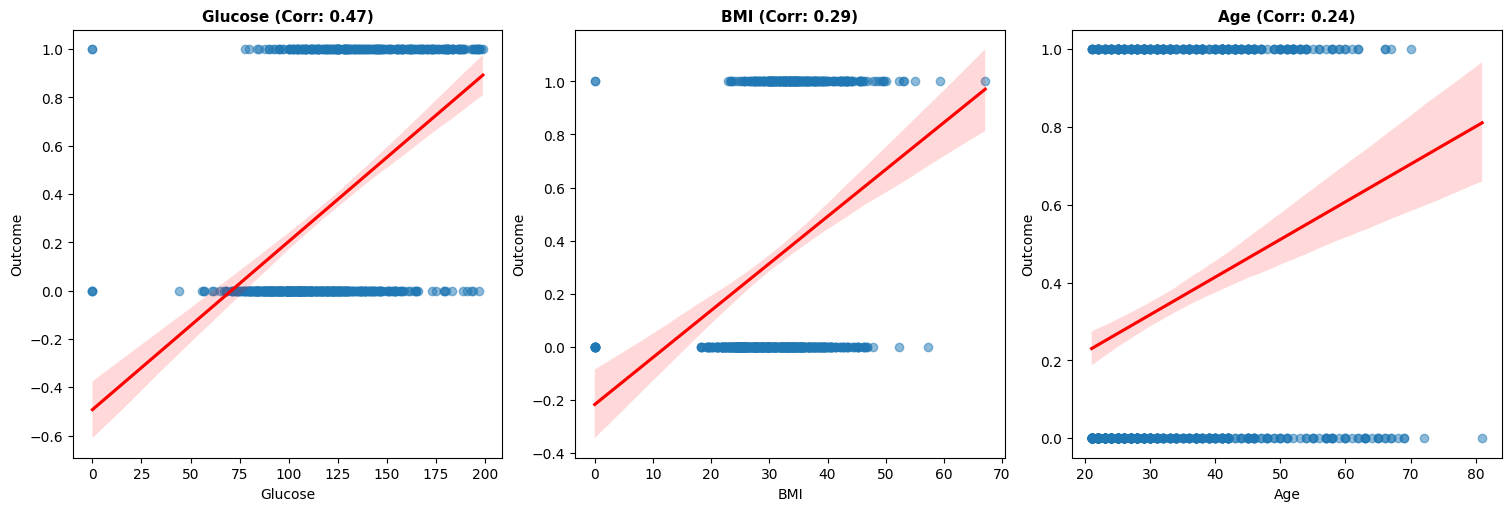

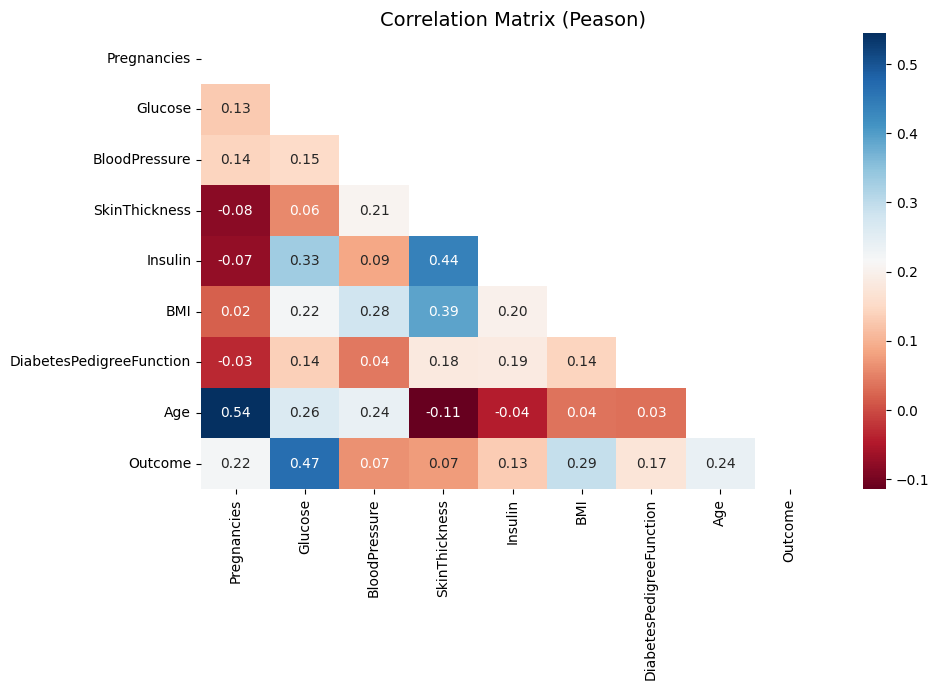

In [4]:
orch.execute_analysis(mode='all')

## 3. Feature Engineering + Data Preparation

The method `prepare_features()` takes all the heavy data processing part and do it automatically:

- Re-check for nulls, filling them if necessary (using median or mode).

- Factorize the categorical columns (and save the encoders).

- Divide the original dataset into two variants: with outliers (raw data) and without outliers (cleaned by Windsorization). 

- To each of those datasets, applies MinMaxScaling and StandardScaling, creating more variants of the two datasets (one for each kind of scaler).

- If passed feature_selection = True (set by default), also will create variants with that filter applied with SelectKBest.

- Save all data, both in the internal object's database and, if selected (set by default), locally.

In [5]:
orch.prepare_features(save_path="./test")

=============== SETTING FEATURE ENGINEERING ===============
---------------------------- Null handling -----------------------------
✅ Nulls:       No missing values detected.
🔢 Encoding:    Factorized 1 categorical columns.
💾 Encoders:    Saved 1 JSON files in './test/encoders'
✂️  Outliers:    Processed 8 numerical columns (IQR Method).

⚙️  Processing Variants...
-------------- Initiating automatic preparation for: with_outliers --------------
Scaler (MinMax) saved in: ./test/scalers/scaler_minmax.pkl
 -> MinMaxScaler applied... 
Scaler (Standard) saved in: ./test/scalers/scaler_standard.pkl
 -> StandardScaler applied... 
 -> Feature selection ON, applying... 
 -> Selected features (5): ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']
💾 Datasets:    Saved 12 files for 'with_outliers' in './test/datasets'
-------------- Initiating automatic preparation for: without_ouliers --------------
Scaler (MinMax) saved in: ./test/scalers/scaler_minmax.pkl
 -> MinMaxScaler a

## 4. Model Training

The method `.initialize_trainer()` deals with the configuration.

- It loads all the models to use for training, either from manual configuration (passing a dict with `{"name": Model()}` with the desired models on model_config) or automatically loaded by default taking in consideration the problem type.

- Also loads the hyper parameter grid (./config/param_config.json by default) with all the iterations for each model to try int he optimization phase. 

In [6]:
config = './config/param_config.json'
orch.initialize_trainer(problem_type='classification', config_path=config)


🥊 --- Initializing ModelTrainer (classification) ---
   -> Loading default configuration for classification...
Added models for: classification
['DecisionTreeClassifier', 'RandomForestClassifier', 'XGBClassifier', 'LogisticRegression', 'SVC']


The method `.run_training_cycle()`, as the name implies, takes all the configurations loaded with `.initialize_trainer()` and proceeds to iterate through them to get the best combination of model + dataset.

- Trains all models with all datasets and gets the metrics depending on the problem type, then sort it by the best score.

- If `overfitting_filter = True` (set by default), it compares the gap between train and test score to possibly filter the overfitted results. This gap is customizable with `gap_threshold` (default = 0.3).

- If `optimization = True` (set by default) it takes the best model and the best dataset to proceed with hyperparameter optimization. After that, retrains the model with the new configuration.

- Saves all the data (best models, best datasets) on the object.

In [7]:
orch.run_training_cycle()


--------------- MODEL TRAINING & EVALUATION ---------------
🏋️  Training 5 models across 10 datasets...


🏆 Winner: 'RandomForestClassifier' on 'X_train_without_ouliers_standard_sel' (Test Score: 0.7857)

📊 Preliminary Results:


,dataset,model,type,metric,train_score,test_score,gap
46,X_train_without_ouliers_standard_sel,RandomForestClassifier,classification,Accuracy,1.000000,0.785714,0.214286
41,X_train_without_ouliers_minmax_sel,RandomForestClassifier,classification,Accuracy,1.000000,0.779221,0.220779
18,X_train_with_outliers_minmax_sel,LogisticRegression,classification,Accuracy,0.754072,0.772727,0.018656
21,X_train_with_outliers_standard_sel,RandomForestClassifier,classification,Accuracy,1.000000,0.772727,0.227273
43,X_train_without_ouliers_minmax_sel,LogisticRegression,classification,Accuracy,0.765472,0.772727,0.007255
16,X_train_with_outliers_minmax_sel,RandomForestClassifier,classification,Accuracy,1.000000,0.766234,0.233766
24,X_train_with_outliers_standard_sel,SVC,classification,Accuracy,0.809446,0.766234,0.043212
28,X_train_without_ouliers,LogisticRegression,classification,Accuracy,0.773616,0.766234,0.007382
49,X_train_without_ouliers_standard_sel,SVC,classification,Accuracy,0.807818,0.766234,0.041584
29,X_train_without_ouliers,SVC,classification,Accuracy,0.765472,0.766234,0.000761



--------------- HYPERPARAMETER OPTIMIZATION ---------------
🔧 Optimizing 'RandomForestClassifier' using dataset 'X_train_without_ouliers_standard_sel'...
Automatic hyperparameter configuration loaded.

✅ Optimization Complete:
╒═══════════════════╤══════════════╕
│ Hyperparam        │ Best Value   │
╞═══════════════════╪══════════════╡
│ criterion         │ entropy      │
├───────────────────┼──────────────┤
│ max_depth         │ 10           │
├───────────────────┼──────────────┤
│ min_samples_leaf  │ 4            │
├───────────────────┼──────────────┤
│ min_samples_split │ 10           │
├───────────────────┼──────────────┤
│ n_estimators      │ 200          │
╘═══════════════════╧══════════════╛
📈 Best CV Score: 0.7802
🧹 Trim: Removed all other models. Keeping only 'RandomForestClassifier_criterion_entropy_max_depth_10_min_samples_leaf_4_min_samples_split_10_n_estimators_200'.

--------------- MODEL TRAINING & EVALUATION ---------------
🏋️  Training 1 models across 10 datasets...
🏆

,dataset,model,type,metric,train_score,test_score,gap
4,X_train_with_outliers_standard_sel,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.903909,0.779221,0.124688
3,X_train_with_outliers_minmax_sel,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.903909,0.779221,0.124688
8,X_train_without_ouliers_minmax_sel,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.902280,0.772727,0.129553
9,X_train_without_ouliers_standard_sel,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.902280,0.772727,0.129553
1,X_train_with_outliers_minmax,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.918567,0.766234,0.152333
0,X_train_with_outliers,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.918567,0.766234,0.152333
5,X_train_without_ouliers,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.918567,0.766234,0.152333
2,X_train_with_outliers_standard,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.918567,0.766234,0.152333
7,X_train_without_ouliers_standard,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.918567,0.766234,0.152333
6,X_train_without_ouliers_minmax,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.921824,0.766234,0.155590


## 5. Artifact saving

An "Artifact" is a pickle-encoded dict that contains: the model configuration, the dataset and the scaler information. This with the objective of transform new data to align with the first train data and retrain the model with new data or make predictions with it.

- `.save_artifacts()`, compiles all the data used on the training process, creates the Artifact and saves it.

In [8]:
orch.save_artifacts()


💾 --- Saving Production Artifacts ---
Best model found, saving: 'RandomForestClassifier_criterion_entropy_max_depth_10_min_samples_leaf_4_min_samples_split_10_n_estimators_200'...
Best dataset found, saving: 'X_train_with_outliers_standard_sel'...
📦 Artifact Saved: ./test/models/RandomForestClassifier_criterion_entropy_max_depth_10_min_samples_leaf_4_min_samples_split_10_n_estimators_200_best.pkl


### BONUS: Pipeline 

For even quicker processing, there's the `.run_pipeline()` method, that, as the name says, it runs the whole process in order. All with the default configuration.


🚀 AUTOMATIC PIPELINE RUNNING: CLASSIFICATION
🎯 Target: 'Outcome' | 📂 Output: './pipeline_test'
✅ Data successfully loaded!
Looks like Outcome is a factorized categorical. Reclassifying...
ℹ️  Column Classification: 8 Numerical | 1 Categorical
🛠️ Tools initialized: DataExplorer & Visualizer ready.

--- 🔍 Starting Analysis (Mode: all) ---

--------------- DATA SUMMARY ---------------
📐 Dimensions:  768 Rows x 9 Columns
📊 Data Types:  1 Categorical, 8 Numerical
✅ Nulls:       None detected.
✅ Duplicates:  None detected.
--------------------------------------------

--------------- UNIVARIATE ANALYSIS ---------------
🔢 Numerical Statistics:
                            count    mean     std    min    25%     50%     75%     max
------------------------  -------  ------  ------  -----  -----  ------  ------  ------
Pregnancies                768.00    3.85    3.37   0.00   1.00    3.00    6.00   17.00
Glucose                    768.00  120.89   31.97   0.00  99.00  117.00  140.25  199.00
Bl

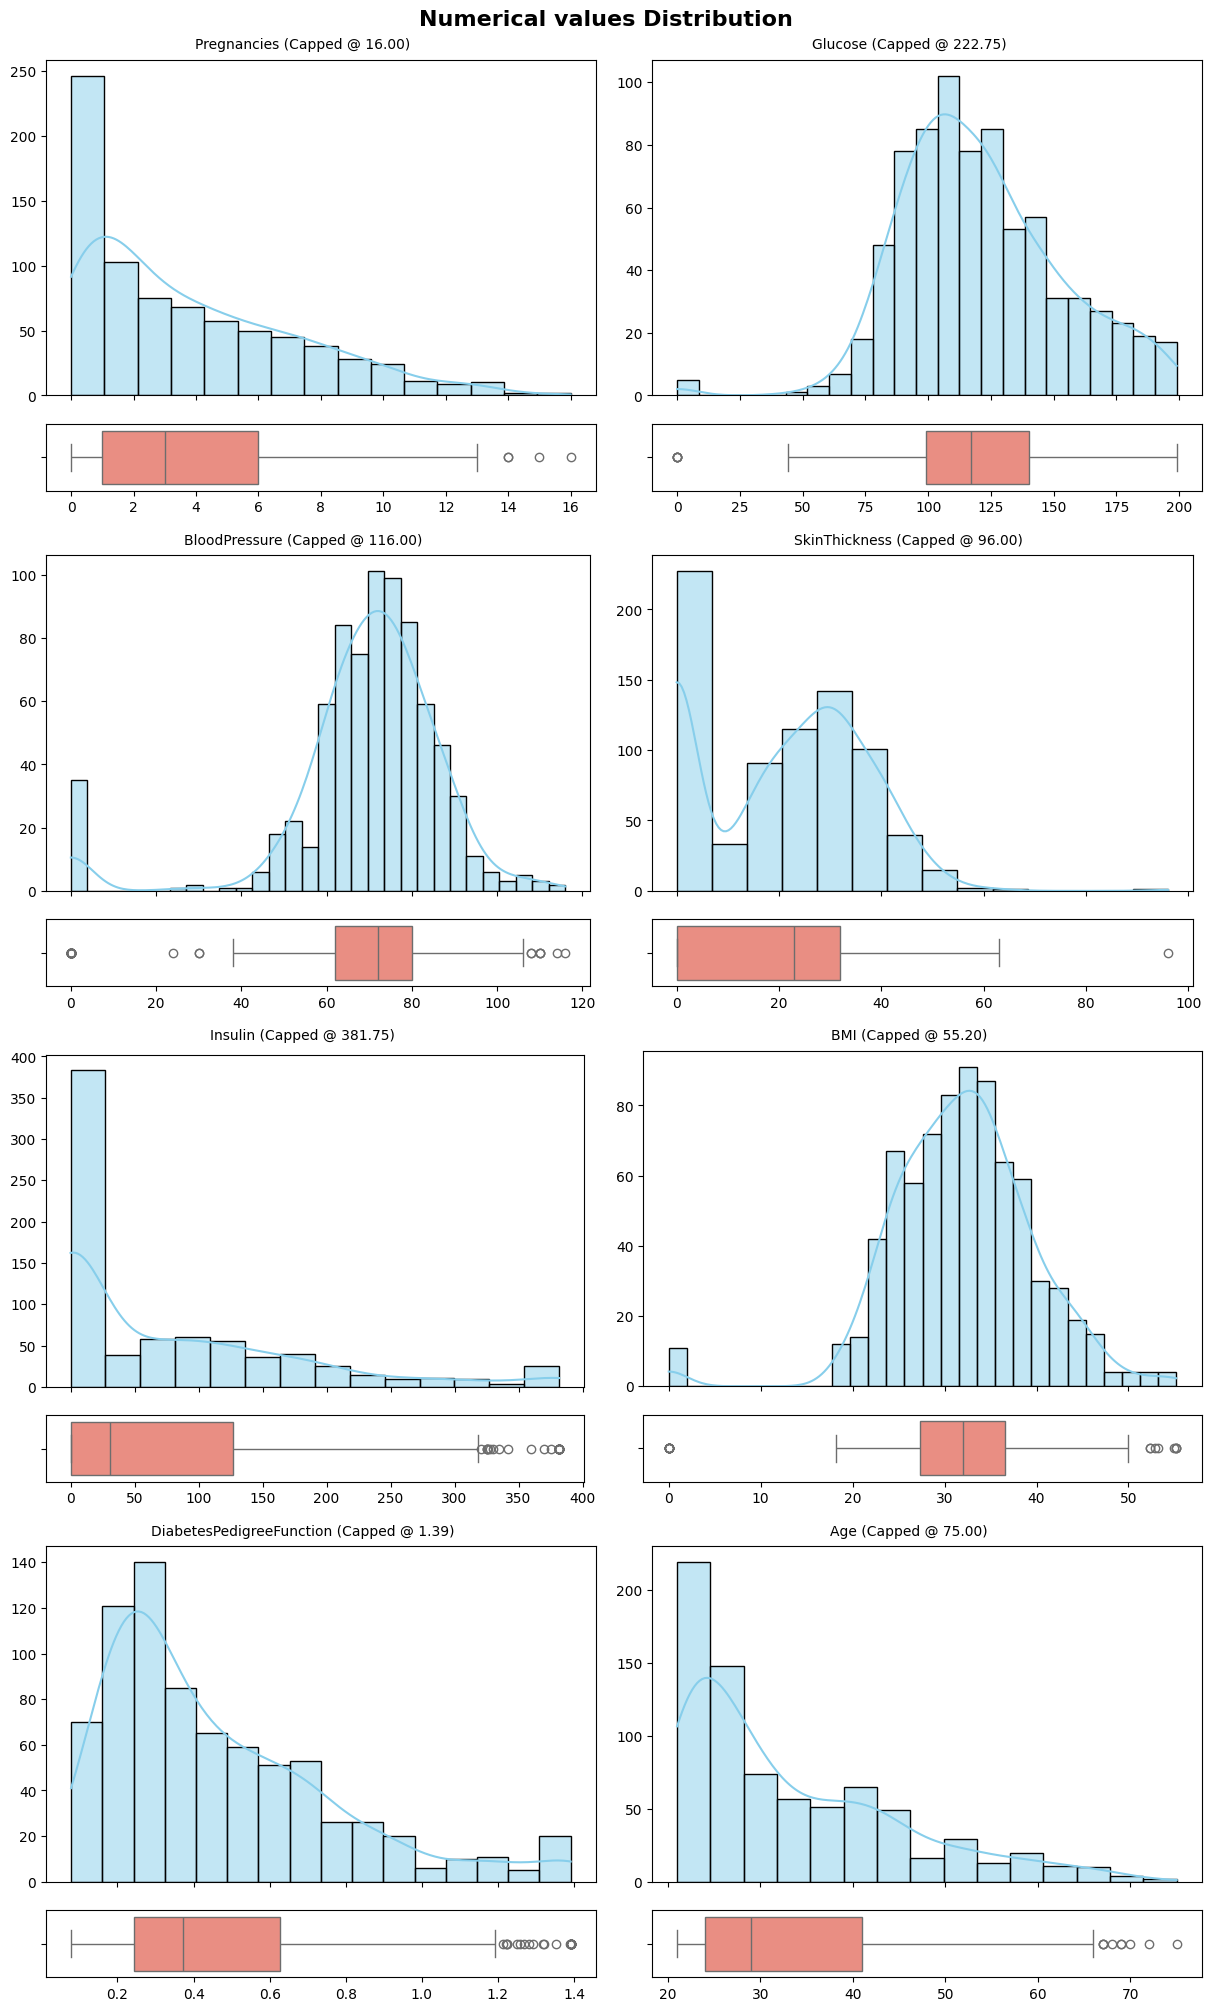

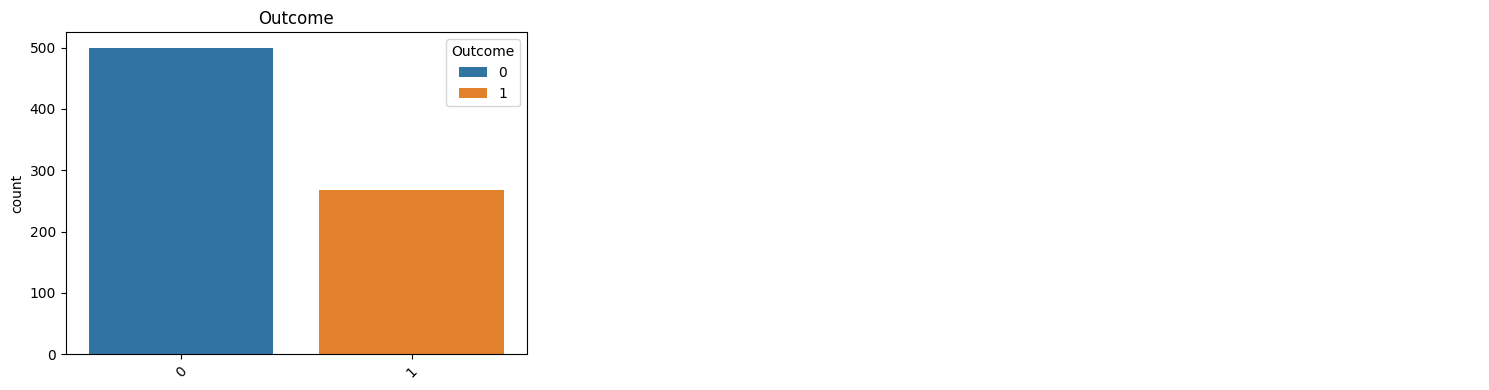

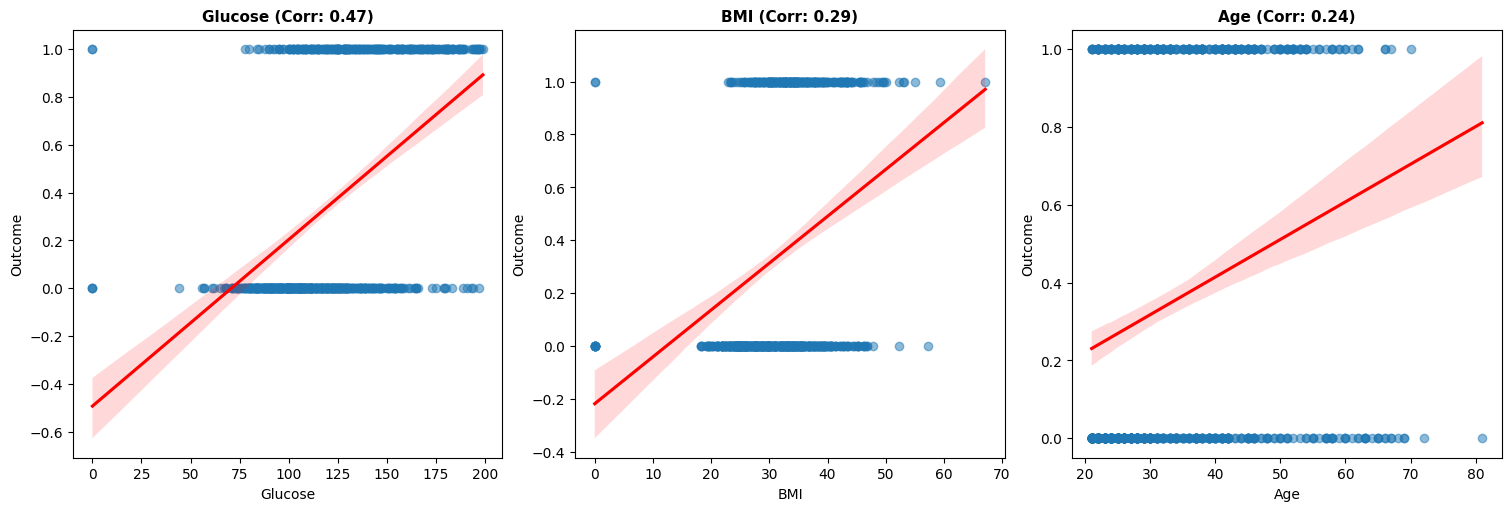

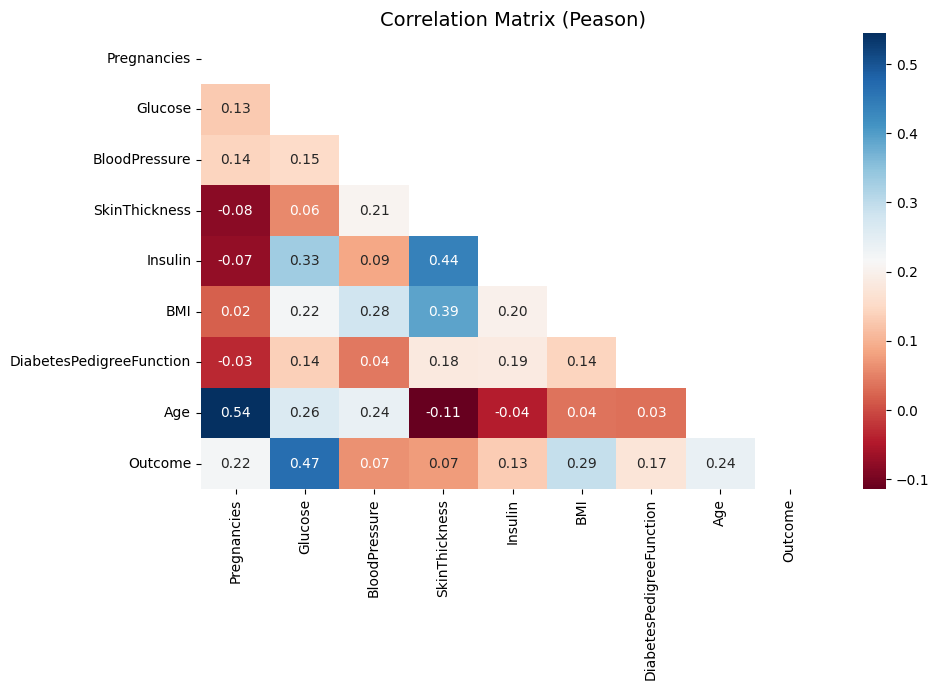

=============== SETTING FEATURE ENGINEERING ===============
---------------------------- Null handling -----------------------------
✅ Nulls:       No missing values detected.
🔢 Encoding:    Factorized 1 categorical columns.
💾 Encoders:    Saved 1 JSON files in './pipeline_test/encoders'
✂️  Outliers:    Processed 8 numerical columns (IQR Method).

⚙️  Processing Variants...
-------------- Initiating automatic preparation for: with_outliers --------------
Scaler (MinMax) saved in: ./pipeline_test/scalers/scaler_minmax.pkl
 -> MinMaxScaler applied... 
Scaler (Standard) saved in: ./pipeline_test/scalers/scaler_standard.pkl
 -> StandardScaler applied... 
 -> Feature selection ON, applying... 
 -> Selected features (5): ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']
💾 Datasets:    Saved 12 files for 'with_outliers' in './pipeline_test/datasets'
-------------- Initiating automatic preparation for: without_ouliers --------------
Scaler (MinMax) saved in: ./pipeline_test

,dataset,model,type,metric,train_score,test_score,gap
46,X_train_without_ouliers_standard_sel,RandomForestClassifier,classification,Accuracy,1.000000,0.785714,0.214286
41,X_train_without_ouliers_minmax_sel,RandomForestClassifier,classification,Accuracy,1.000000,0.779221,0.220779
18,X_train_with_outliers_minmax_sel,LogisticRegression,classification,Accuracy,0.754072,0.772727,0.018656
21,X_train_with_outliers_standard_sel,RandomForestClassifier,classification,Accuracy,1.000000,0.772727,0.227273
43,X_train_without_ouliers_minmax_sel,LogisticRegression,classification,Accuracy,0.765472,0.772727,0.007255
16,X_train_with_outliers_minmax_sel,RandomForestClassifier,classification,Accuracy,1.000000,0.766234,0.233766
24,X_train_with_outliers_standard_sel,SVC,classification,Accuracy,0.809446,0.766234,0.043212
28,X_train_without_ouliers,LogisticRegression,classification,Accuracy,0.773616,0.766234,0.007382
49,X_train_without_ouliers_standard_sel,SVC,classification,Accuracy,0.807818,0.766234,0.041584
29,X_train_without_ouliers,SVC,classification,Accuracy,0.765472,0.766234,0.000761



--------------- HYPERPARAMETER OPTIMIZATION ---------------
🔧 Optimizing 'RandomForestClassifier' using dataset 'X_train_without_ouliers_standard_sel'...
Automatic hyperparameter configuration loaded.

✅ Optimization Complete:
╒═══════════════════╤══════════════╕
│ Hyperparam        │ Best Value   │
╞═══════════════════╪══════════════╡
│ criterion         │ entropy      │
├───────────────────┼──────────────┤
│ max_depth         │ 10           │
├───────────────────┼──────────────┤
│ min_samples_leaf  │ 4            │
├───────────────────┼──────────────┤
│ min_samples_split │ 10           │
├───────────────────┼──────────────┤
│ n_estimators      │ 200          │
╘═══════════════════╧══════════════╛
📈 Best CV Score: 0.7802
🧹 Trim: Removed all other models. Keeping only 'RandomForestClassifier_criterion_entropy_max_depth_10_min_samples_leaf_4_min_samples_split_10_n_estimators_200'.

--------------- MODEL TRAINING & EVALUATION ---------------
🏋️  Training 1 models across 10 datasets...
🏆

,dataset,model,type,metric,train_score,test_score,gap
4,X_train_with_outliers_standard_sel,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.903909,0.779221,0.124688
3,X_train_with_outliers_minmax_sel,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.903909,0.779221,0.124688
8,X_train_without_ouliers_minmax_sel,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.902280,0.772727,0.129553
9,X_train_without_ouliers_standard_sel,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.902280,0.772727,0.129553
1,X_train_with_outliers_minmax,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.918567,0.766234,0.152333
0,X_train_with_outliers,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.918567,0.766234,0.152333
5,X_train_without_ouliers,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.918567,0.766234,0.152333
2,X_train_with_outliers_standard,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.918567,0.766234,0.152333
7,X_train_without_ouliers_standard,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.918567,0.766234,0.152333
6,X_train_without_ouliers_minmax,RandomForestClassifier_criterion_entropy_max_d...,classification,Accuracy,0.921824,0.766234,0.155590



💾 --- Saving Production Artifacts ---
Best model found, saving: 'RandomForestClassifier_criterion_entropy_max_depth_10_min_samples_leaf_4_min_samples_split_10_n_estimators_200'...
Best dataset found, saving: 'X_train_with_outliers_standard_sel'...
📦 Artifact Saved: ./pipeline_test/models/RandomForestClassifier_criterion_entropy_max_depth_10_min_samples_leaf_4_min_samples_split_10_n_estimators_200_best.pkl

✅ PIPELINE FINISHED SUCCESSFULLY
📁 Results saved on: './pipeline_test'



In [12]:
orch_2 = MLOrchestrator()
orch_2.run_pipeline(df_path=df_path, target= "Outcome", problem_type="classification", analysis_mode= 'all', config_path= "./config/param_config.json", save_path="./pipeline_test")